In [1]:
%pip install tensorflow
%pip install numpy
%pip install matplotlib
%pip install pandas
%pip install keras

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Layer
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, Callback
from tensorflow.keras import initializers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Mean

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import TensorBoard
import datetime

## i) Use custom learning rate scheduler



Epoch 1/20


1563/1563 [==============================] - 8s 5ms/step - loss: 1.6453 - accuracy: 0.3902 - val_loss: 1.2901 - val_accuracy: 0.5317 - lr: 0.0010
Epoch 2/20
1563/1563 [==============================] - 7s 5ms/step - loss: 1.2634 - accuracy: 0.5527 - val_loss: 1.1198 - val_accuracy: 0.5968 - lr: 0.0010
Epoch 3/20
1563/1563 [==============================] - 7s 5ms/step - loss: 1.1142 - accuracy: 0.6073 - val_loss: 1.0089 - val_accuracy: 0.6393 - lr: 0.0010
Epoch 4/20
1563/1563 [==============================] - 7s 4ms/step - loss: 1.0128 - accuracy: 0.6455 - val_loss: 0.9578 - val_accuracy: 0.6666 - lr: 0.0010
Epoch 5/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9328 - accuracy: 0.6765 - val_loss: 0.9120 - val_accuracy: 0.6835 - lr: 0.0010
Epoch 6/20
1563/1563 [==============================] - 7s 4ms/step - loss: 0.8688 - accuracy: 0.6969 - val_loss: 0.8827 - val_accuracy: 0.6936 - lr: 0.0010
Epoch 7/20
1563/1563 [==============================] 

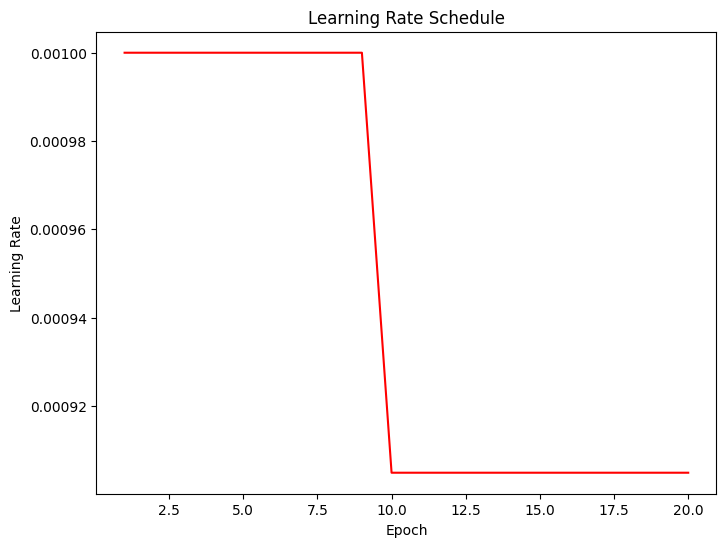

313/313 - 0s - loss: 0.9101 - accuracy: 0.7331 - 495ms/epoch - 2ms/step
Test accuracy: 0.7330999970436096


In [3]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Define a custom learning rate scheduler
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Create a callback for the learning rate scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), callbacks=[lr_scheduler])

# Plot the learning rate over time
epochs = range(1, 21)
learning_rates = [lr_schedule(i, 0.001) for i in epochs]
plt.figure(figsize=(8, 6))
plt.plot(epochs, learning_rates, 'r-')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

## ii) use custom dropout

In [5]:
# Define a custom Dropout layer
class CustomDropout(Layer):
    def __init__(self, rate, **kwargs):
        super(CustomDropout, self).__init__(**kwargs)
        self.rate = rate

    def call(self, inputs, training=None):
        if training:
            return tf.nn.dropout(inputs, rate=self.rate)
        return inputs

# Callback to adjust dropout rate
class DropoutScheduler(Callback):
    def __init__(self, rate_schedule):
        super(DropoutScheduler, self).__init__()
        self.rate_schedule = rate_schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.layers[6], 'rate'):
            raise ValueError('Dropout rate scheduling applied to a non-dropout layer.')
        # Adjust the dropout rate based on the epoch number
        new_rate = self.rate_schedule(epoch)
        self.model.layers[6].rate = new_rate
        print(f"Dropout rate set to {new_rate} for epoch {epoch+1}")

# Define a rate schedule function
def rate_schedule(epoch):
    if epoch < 10:
        return 0.2  # Higher dropout initially
    elif epoch < 20:
        return 0.1  # Reduced dropout later
    else:
        return 0.05  # Minimal dropout towards the end

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    CustomDropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Create a callback for the custom dropout scheduler
dropout_scheduler = DropoutScheduler(rate_schedule)

# Train the model
history = model.fit(x_train, y_train, epochs=30, validation_data=(x_test, y_test), callbacks=[dropout_scheduler])

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

Dropout rate set to 0.2 for epoch 1
Epoch 1/30
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5282 - accuracy: 0.4401 - val_loss: 1.2248 - val_accuracy: 0.5620
Dropout rate set to 0.2 for epoch 2
Epoch 2/30
1563/1563 [==============================] - 7s 5ms/step - loss: 1.1627 - accuracy: 0.5872 - val_loss: 1.1149 - val_accuracy: 0.6012
Dropout rate set to 0.2 for epoch 3
Epoch 3/30
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0004 - accuracy: 0.6471 - val_loss: 0.9729 - val_accuracy: 0.6576
Dropout rate set to 0.2 for epoch 4
Epoch 4/30
1563/1563 [==============================] - 7s 5ms/step - loss: 0.8947 - accuracy: 0.6868 - val_loss: 0.8575 - val_accuracy: 0.6982
Dropout rate set to 0.2 for epoch 5
Epoch 5/30
1563/1563 [==============================] - 7s 5ms/step - loss: 0.8184 - accuracy: 0.7157 - val_loss: 0.8659 - val_accuracy: 0.6982
Dropout rate set to 0.2 for epoch 6
Epoch 6/30
1563/1563 [==============================] - 7s 5ms/s

## iii) Use custom normalization

In [8]:
# Define a custom Normalization layer
class CustomNormalization(Layer):
    def __init__(self, mean=0.0, stddev=1.0, **kwargs):
        super(CustomNormalization, self).__init__(**kwargs)
        # Mean and standard deviation for normalization
        self.mean = mean
        self.stddev = stddev

    def call(self, inputs):
        # Standardize inputs
        return (inputs - self.mean) / self.stddev

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Compute global mean and standard deviation
mean = np.mean(x_train)
stddev = np.std(x_train)

# Normalize the images using computed mean and stddev
x_train = (x_train - mean) / stddev
x_test = (x_test - mean) / stddev

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Build the CNN model
model = Sequential([
    CustomNormalization(mean=mean, stddev=stddev, input_shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

Epoch 1/20
1563/1563 [==============================] - 8s 5ms/step - loss: 2.3031 - accuracy: 0.0996 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 2/20
1563/1563 [==============================] - 7s 5ms/step - loss: 2.3028 - accuracy: 0.0975 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/20
1563/1563 [==============================] - 7s 5ms/step - loss: 2.3028 - accuracy: 0.1000 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 4/20
1563/1563 [==============================] - 7s 5ms/step - loss: 2.3028 - accuracy: 0.0978 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/20
1563/1563 [==============================] - 7s 5ms/step - loss: 2.3028 - accuracy: 0.0987 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/20
1563/1563 [==============================] - 7s 4ms/step - loss: 2.3028 - accuracy: 0.0995 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 7/20
1563/1563 [==============================] - 7s 4ms/step - loss: 2.3028 - accuracy: 0.0979 - val_loss: 2.3027 - val_accuracy:

## iv) use tensorboard

In [55]:
# remove tb-nightly due to compatibility issues with tensorboard
%pip uninstall tb-nightly tensorboard
%pip install tensorboard

^C
Note: you may need to restart the kernel to use updated packages.



In [56]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Set up TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test),
                    callbacks=[tensorboard_callback])

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

# Instructions to open TensorBoard in Colab
%load_ext tensorboard
%tensorboard --logdir logs/fit


Epoch 1/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.6418 - accuracy: 0.3967 - val_loss: 1.2792 - val_accuracy: 0.5395
Epoch 2/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.2730 - accuracy: 0.5453 - val_loss: 1.1490 - val_accuracy: 0.5940
Epoch 3/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.1166 - accuracy: 0.6048 - val_loss: 1.0365 - val_accuracy: 0.6352
Epoch 4/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.0104 - accuracy: 0.6480 - val_loss: 0.9440 - val_accuracy: 0.6661
Epoch 5/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.9308 - accuracy: 0.6758 - val_loss: 0.9043 - val_accuracy: 0.6871
Epoch 6/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.8724 - accuracy: 0.6976 - val_loss: 0.8893 - val_accuracy: 0.6879
Epoch 7/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.8201 - accuracy: 0.7156 - val_loss: 0.8888 - val_accuracy:

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\Nickk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\Scripts\tensorboard.exe\__main__.py", line 7, in <module>
  File "C:\Users\Nickk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorboard\main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "C:\Users\Nickk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\absl\app.py", line 308, in run
    _run_main(main, args)
  File "C:\Users\Nickk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\si

## v) use custom loss function

In [10]:
# Define a custom loss function
def custom_loss(y_true, y_pred):
    # Calculate the mean squared error
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    # Calculate the mean absolute error as well
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    # Combine these errors to form a new loss
    return mse + mae

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model with the custom loss function
model.compile(optimizer='adam',
              loss=custom_loss,
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

Epoch 1/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.2042 - accuracy: 0.4118 - val_loss: 0.1753 - val_accuracy: 0.5134
Epoch 2/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.1592 - accuracy: 0.5607 - val_loss: 0.1530 - val_accuracy: 0.5774
Epoch 3/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.1412 - accuracy: 0.6149 - val_loss: 0.1463 - val_accuracy: 0.5963
Epoch 4/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.1296 - accuracy: 0.6479 - val_loss: 0.1359 - val_accuracy: 0.6290
Epoch 5/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.1210 - accuracy: 0.6734 - val_loss: 0.1313 - val_accuracy: 0.6422
Epoch 6/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.1141 - accuracy: 0.6924 - val_loss: 0.1253 - val_accuracy: 0.6600
Epoch 7/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.1075 - accuracy: 0.7116 - val_loss: 0.1265 - val_accuracy:

## vi) use custom activation function, initializer regularizer and kernel weight constraint

In [15]:
# Define a custom activation function
def custom_activation(x):
    return tf.nn.relu(x) * tf.math.log(1 + tf.exp(x))

# Custom initializer
class CustomInitializer(initializers.Initializer):
    def __call__(self, shape, dtype=None):
        return tf.random.normal(shape, mean=0.0, stddev=0.05, dtype=dtype)

# Custom regularizer
def l2_custom_reg(weight_matrix):
    return 0.01 * tf.reduce_sum(tf.square(weight_matrix))

# Custom kernel constraint
def custom_constraint(w):
    return tf.clip_by_value(w, -0.05, 0.05)  # Constraining weights between -0.05 and 0.05

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation=custom_activation, kernel_initializer=CustomInitializer(),
           kernel_regularizer=l2_custom_reg, kernel_constraint=custom_constraint,
           input_shape=(32, 32, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation=custom_activation, kernel_initializer=CustomInitializer(),
           kernel_regularizer=l2_custom_reg, kernel_constraint=custom_constraint),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation=custom_activation, kernel_initializer=CustomInitializer(),
           kernel_regularizer=l2_custom_reg, kernel_constraint=custom_constraint),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation=custom_activation, kernel_initializer=CustomInitializer(),
          kernel_regularizer=l2_custom_reg, kernel_constraint=custom_constraint),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

Epoch 1/10
1563/1563 [==============================] - 12s 7ms/step - loss: 2.3276 - accuracy: 0.1002 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 2/10
1563/1563 [==============================] - 11s 7ms/step - loss: 2.3028 - accuracy: 0.0984 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/10
1563/1563 [==============================] - 11s 7ms/step - loss: 2.3028 - accuracy: 0.0986 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/10
1563/1563 [==============================] - 11s 7ms/step - loss: 2.3028 - accuracy: 0.0980 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/10
1563/1563 [==============================] - 11s 7ms/step - loss: 2.3027 - accuracy: 0.1001 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 6/10
1563/1563 [==============================] - 11s 7ms/step - loss: 2.3027 - accuracy: 0.1000 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 7/10
1563/1563 [==============================] - 11s 7ms/step - loss: 2.3028 - accuracy: 0.1000 - val_loss: 2.3026 - val_ac

## vii) use custom metric

In [16]:
# Define a custom metric
def custom_accuracy(y_true, y_pred):
    # Calculate how many predictions have the highest probability matching the true label
    return tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1)), tf.float32))

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model with the custom metric
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[custom_accuracy])

# Train the model
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_custom_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f'Test custom accuracy: {test_custom_accuracy}')

Epoch 1/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5364 - custom_accuracy: 0.4377 - val_loss: 1.2851 - val_custom_accuracy: 0.5373
Epoch 2/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.1411 - custom_accuracy: 0.5949 - val_loss: 1.0818 - val_custom_accuracy: 0.6191
Epoch 3/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.9722 - custom_accuracy: 0.6552 - val_loss: 0.9765 - val_custom_accuracy: 0.6560
Epoch 4/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.8620 - custom_accuracy: 0.6967 - val_loss: 0.9277 - val_custom_accuracy: 0.6767
Epoch 5/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.7802 - custom_accuracy: 0.7253 - val_loss: 0.8535 - val_custom_accuracy: 0.7111
Epoch 6/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.7173 - custom_accuracy: 0.7471 - val_loss: 0.8535 - val_custom_accuracy: 0.7051
Epoch 7/10
1563/1563 [==============================

## viii) Use custom layers

In [17]:
# Define a custom layer
class CustomLayer(Layer):
    def __init__(self, num_outputs, **kwargs):
        super(CustomLayer, self).__init__(**kwargs)
        self.num_outputs = num_outputs

    def build(self, input_shape):
        # Create a trainable weight for this layer
        self.kernel = self.add_weight("kernel",
                                      shape=[int(input_shape[-1]),
                                             self.num_outputs])

    def call(self, inputs):
        # Define the forward pass
        return tf.matmul(inputs, self.kernel)

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    CustomLayer(128),  # Using the custom layer here
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

Epoch 1/20
1563/1563 [==============================] - 8s 5ms/step - loss: 1.4662 - accuracy: 0.4637 - val_loss: 1.1817 - val_accuracy: 0.5811
Epoch 2/20
1563/1563 [==============================] - 7s 4ms/step - loss: 1.0701 - accuracy: 0.6229 - val_loss: 1.0612 - val_accuracy: 0.6223
Epoch 3/20
1563/1563 [==============================] - 7s 4ms/step - loss: 0.9228 - accuracy: 0.6747 - val_loss: 0.9465 - val_accuracy: 0.6696
Epoch 4/20
1563/1563 [==============================] - 7s 4ms/step - loss: 0.8156 - accuracy: 0.7144 - val_loss: 0.9904 - val_accuracy: 0.6662
Epoch 5/20
1563/1563 [==============================] - 7s 4ms/step - loss: 0.7436 - accuracy: 0.7398 - val_loss: 0.8873 - val_accuracy: 0.6961
Epoch 6/20
1563/1563 [==============================] - 7s 4ms/step - loss: 0.6891 - accuracy: 0.7567 - val_loss: 0.8690 - val_accuracy: 0.7050
Epoch 7/20
1563/1563 [==============================] - 7s 5ms/step - loss: 0.6354 - accuracy: 0.7761 - val_loss: 0.8439 - val_accuracy:

## ix) Use custom model

In [18]:
# Define a custom model by subclassing Model class
class CustomModel(Model):
    def __init__(self):
        super(CustomModel, self).__init__()
        # Define all layers in the initializer
        self.conv1 = Conv2D(32, (3, 3), activation='relu')
        self.pool1 = MaxPooling2D(2, 2)
        self.conv2 = Conv2D(64, (3, 3), activation='relu')
        self.pool2 = MaxPooling2D(2, 2)
        self.conv3 = Conv2D(128, (3, 3), activation='relu')
        self.pool3 = MaxPooling2D(2, 2)
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10, activation='softmax')

    def call(self, inputs, training=None):
        # Define the forward pass
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Instantiate the custom model
model = CustomModel()

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

Epoch 1/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5291 - accuracy: 0.4432 - val_loss: 1.3001 - val_accuracy: 0.5462
Epoch 2/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.1495 - accuracy: 0.5924 - val_loss: 1.1428 - val_accuracy: 0.6045
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0010 - accuracy: 0.6475 - val_loss: 1.0034 - val_accuracy: 0.6496
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8955 - accuracy: 0.6841 - val_loss: 0.9202 - val_accuracy: 0.6832
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8178 - accuracy: 0.7129 - val_loss: 0.8943 - val_accuracy: 0.6929
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.7455 - accuracy: 0.7378 - val_loss: 0.8512 - val_accuracy: 0.7074
Epoch 7/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.6902 - accuracy: 0.7572 - val_loss: 0.9144 - val_accuracy:

## x) Custom optimizer

In [ ]:
# Not implemented, TensorFlow has an issue that prevents this from working

## xi) Custom Training Loop

In [18]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshape the labels
y_train, y_test = y_train.flatten(), y_test.flatten()

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model (not using model.compile())
loss_object = SparseCategoricalCrossentropy()
optimizer = Adam()

# Define metrics
train_loss = Mean(name='train_loss')
train_accuracy = SparseCategoricalAccuracy(name='train_accuracy')
test_loss = Mean(name='test_loss')
test_accuracy = SparseCategoricalAccuracy(name='test_accuracy')

# Custom training step function


@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

# Custom test step function


@tf.function
def test_step(images, labels):
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)


# Training loop
epochs = 10
for epoch in range(epochs):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in zip(x_train, y_train):
        images = tf.expand_dims(images, 0)
        labels = tf.expand_dims(labels, 0)
        train_step(images, labels)

    for test_images, test_labels in zip(x_test, y_test):
        test_images = tf.expand_dims(test_images, 0)
        test_labels = tf.expand_dims(test_labels, 0)
        test_step(test_images, test_labels)

    print(f'Epoch {epoch + 1}, '
          f'Loss: {train_loss.result()}, '
          f'Accuracy: {train_accuracy.result() * 100}, '
          f'Test Loss: {test_loss.result()}, '
          f'Test Accuracy: {test_accuracy.result() * 100}')

# Final evaluation on the test dataset
final_test_loss, final_test_acc = test_loss.result(), test_accuracy.result() * 100
print(
    f'Final Test Loss: {final_test_loss}, Final Test Accuracy: {final_test_acc}')

Epoch 1, Loss: 1.553449034690857, Accuracy: 43.15399932861328, Test Loss: 1.3285986185073853, Test Accuracy: 52.869998931884766
Epoch 2, Loss: 1.3094278573989868, Accuracy: 53.85000228881836, Test Loss: 1.4072015285491943, Test Accuracy: 52.499996185302734
Epoch 3, Loss: 1.2492620944976807, Accuracy: 56.44599914550781, Test Loss: 1.3364161252975464, Test Accuracy: 54.57999801635742
Epoch 4, Loss: 1.2205687761306763, Accuracy: 58.18199920654297, Test Loss: 1.2362990379333496, Test Accuracy: 57.630001068115234
Epoch 5, Loss: 1.1933887004852295, Accuracy: 59.27000045776367, Test Loss: 1.2947654724121094, Test Accuracy: 56.660003662109375
Epoch 6, Loss: 1.1720436811447144, Accuracy: 59.947998046875, Test Loss: 1.2488739490509033, Test Accuracy: 57.83000183105469
Epoch 7, Loss: 1.1582310199737549, Accuracy: 60.66600036621094, Test Loss: 1.2038357257843018, Test Accuracy: 59.92000198364258
Epoch 8, Loss: 1.160636067390442, Accuracy: 60.805999755859375, Test Loss: 1.318093180656433, Test Accu